In [5]:
pip install qiskit 

Note: you may need to restart the kernel to use updated packages.


In [1]:
import qiskit
print(qiskit.__version__)

1.3.0


In [3]:
pip install qiskit-optimization

  Using cached qiskit_optimization-0.6.1-py3-none-any.whl.metadata (8.6 kB)
  Using cached qiskit_algorithms-0.3.1-py3-none-any.whl.metadata (4.2 kB)
Using cached qiskit_optimization-0.6.1-py3-none-any.whl (167 kB)
Using cached qiskit_algorithms-0.3.1-py3-none-any.whl (310 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install qiskit-machine-learning

Note: you may need to restart the kernel to use updated packages.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit

In [3]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [5]:
x = iris_data.data
y = iris_data.target

## Normalisasi Data

In [8]:
from sklearn.preprocessing import MinMaxScaler
x_normal = MinMaxScaler().fit_transform(x)

## Split Data menjadi data training dan testing

In [11]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.8, random_state=algorithm_globals.random_seed)

## Feature Map

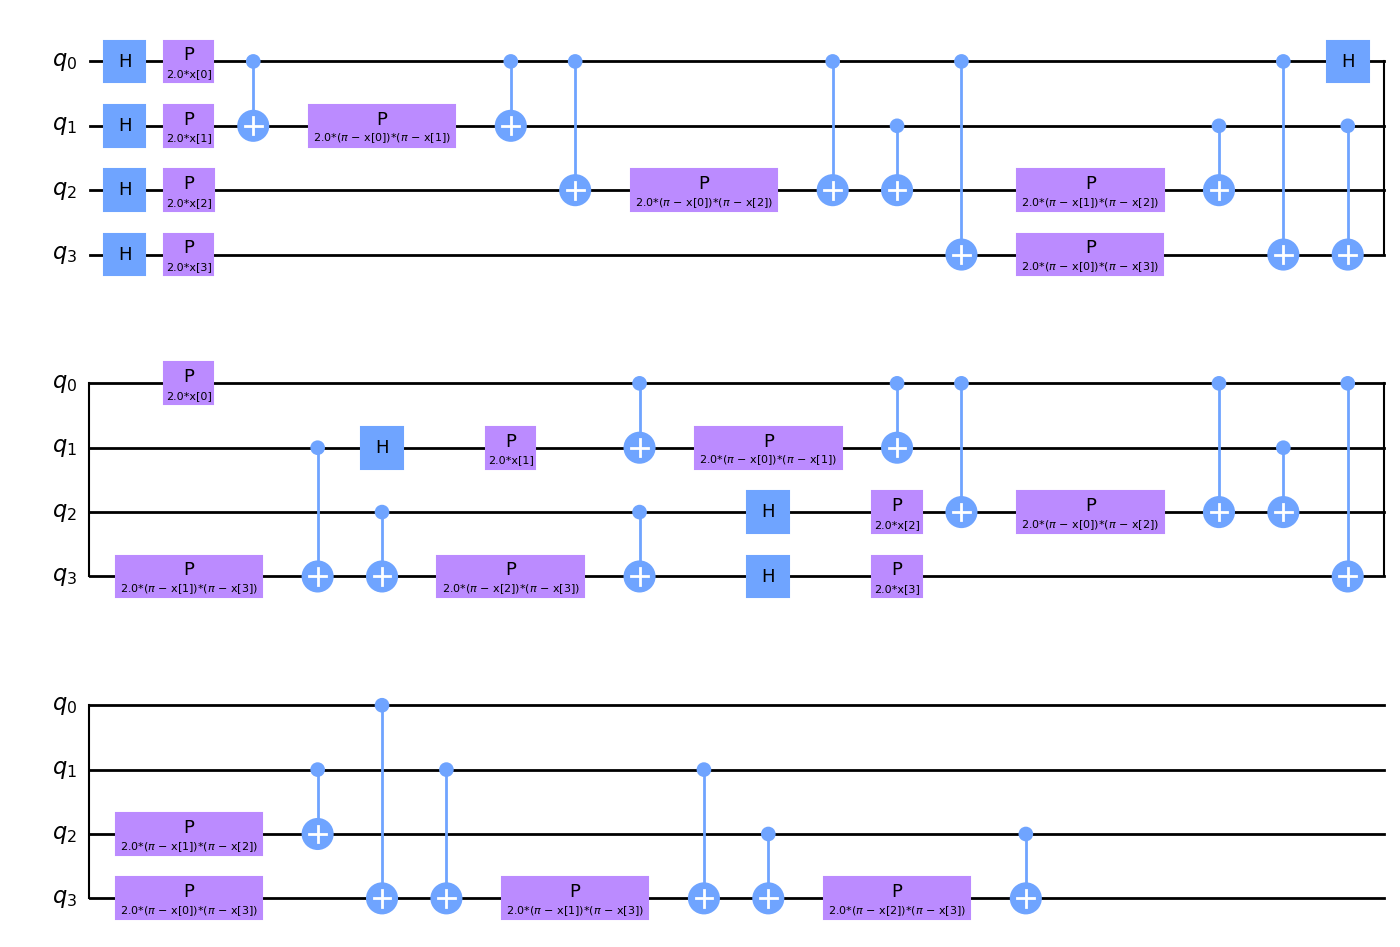

In [16]:
from qiskit.circuit.library import ZZFeatureMap

jum_fitur = x.shape[1]

feature_map = ZZFeatureMap(feature_dimension=jum_fitur, reps=2)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

## Ansatz

from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=jum_fitur, reps=5)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

## Optimasi dengan Cobyla

In [24]:
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [26]:
from qiskit.primitives import Sampler

sampler = Sampler()

C:\Users\user\AppData\Local\Temp\ipykernel_8344\2087805081.py:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


## Fungsi pelatihan

In [29]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

## Algoritma QML: VQC

In [32]:
import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

## Training Model

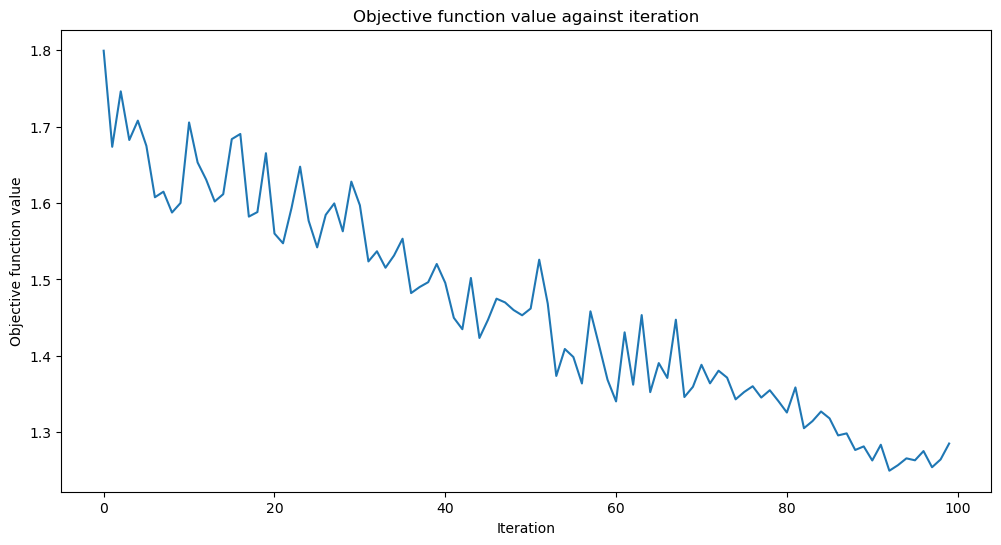

Training time: 377 seconds


In [35]:
objective_func_vals = []

start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

## Pengujian dataset dengan VQC

In [39]:
score_training = vqc.score(train_x, train_y)
score_test = vqc.score(test_x, test_y)

print(f"Quantum VQC on the training dataset: {score_training:.2f}")
print(f"Quantum VQC on the test dataset:     {score_test:.2f}")

Quantum VQC on the training dataset: 0.62
Quantum VQC on the test dataset:     0.53


## Reduksi fitur melalui PCA

<Axes: >

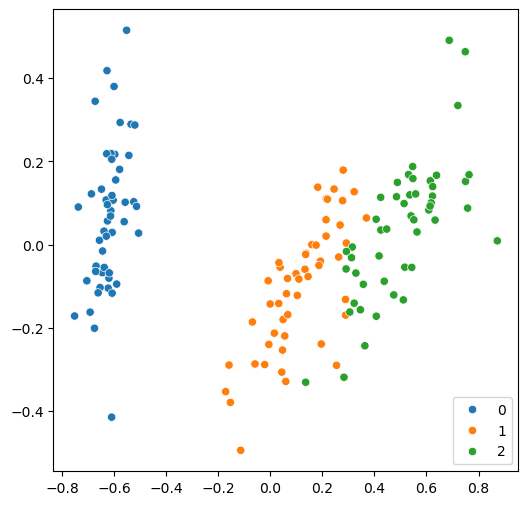

In [42]:
from sklearn.datasets import load_iris

iris_data = load_iris()

features = iris_data.data
labels = iris_data.target

from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

features = PCA(n_components=2).fit_transform(features)

plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=features[:, 0], y=features[:, 1], hue=labels, palette="tab10")

## Split Data, Feature Map, Ansatz, dan Optimizer

In [46]:
train_x, test_x, train_y, test_y = train_test_split(features, labels, train_size=0.8, random_state=algorithm_globals.random_seed)

from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=2)
ansatz = RealAmplitudes(num_qubits=num_features, reps=5)

optimizer = COBYLA(maxiter=40)

## Model Training

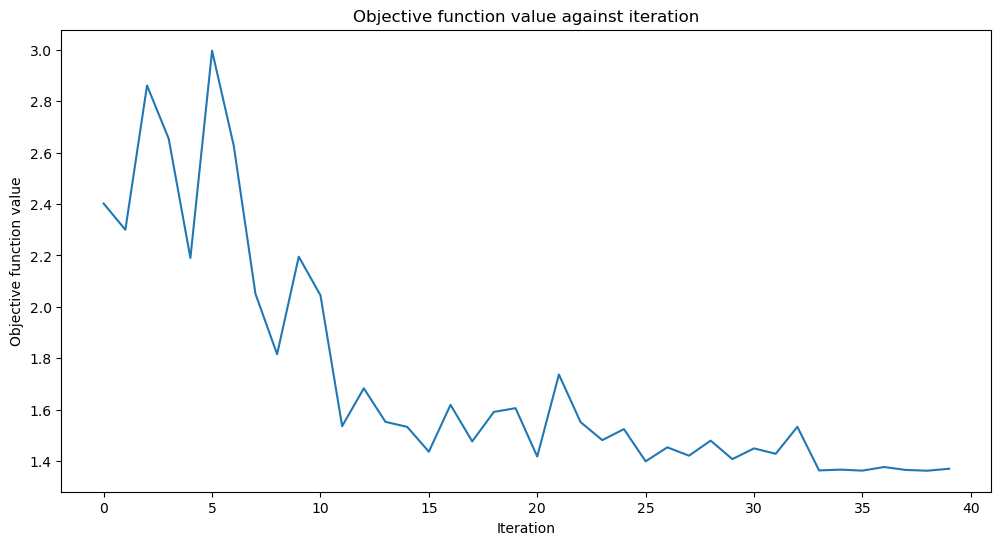

Training time: 76 seconds


In [49]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

# make the objective function plot look nicer.
plt.rcParams["figure.figsize"] = (12, 6)


start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

## Perhitungan Akurasi

In [52]:
train_score_q2_ra = vqc.score(train_x, train_y)
test_score_q2_ra = vqc.score(test_x, test_y)

print(f"Quantum VQC on the training dataset using RealAmplitudes: {train_score_q2_ra:.2f}")
print(f"Quantum VQC on the test dataset using RealAmplitudes:     {test_score_q2_ra:.2f}")

Quantum VQC on the training dataset using RealAmplitudes: 0.57
Quantum VQC on the test dataset using RealAmplitudes:     0.53


## Menggunakan Ansatz lain

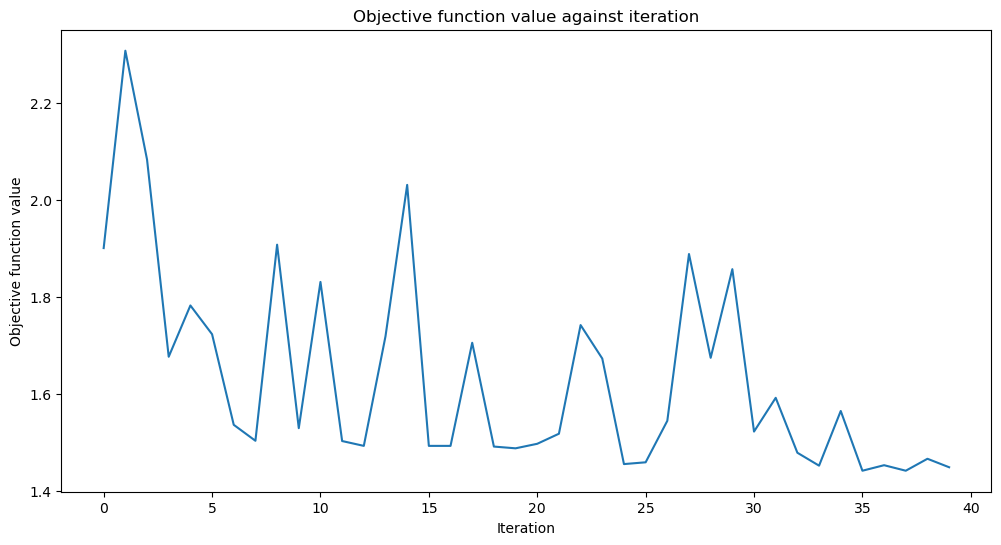

Training time: 77 seconds


In [57]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(num_qubits=num_features, reps=3)
optimizer = COBYLA(maxiter=40)

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_x, train_y)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

## Pengujian Akurasi Model

In [60]:
train_score_q2_eff = vqc.score(train_x, train_y)
test_score_q2_eff = vqc.score(test_x, test_y)

print(f"Quantum VQC on the training dataset using EfficientSU2: {train_score_q2_eff:.2f}")
print(f"Quantum VQC on the test dataset using EfficientSU2:     {test_score_q2_eff:.2f}")

Quantum VQC on the training dataset using EfficientSU2: 0.57
Quantum VQC on the test dataset using EfficientSU2:     0.60
